In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf
import scipy.io

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

We will check the downloaded the dataset google svhn format 2. The data consists of single digit of house number on a 32x32 image. The labels are 1 to 10 (10 classes, '0' has babel 10). The training set has about 70k and the testset around 26k labeled examples. 


In [2]:
data_root = '.' # change to store data elsewhere
train_file = os.path.join(data_root, 'train_32x32.mat')
test_file = os.path.join(data_root, 'test_32x32.mat')

# load train/test dataset
train_data = scipy.io.loadmat(train_file, variable_names = 'X').get('X')
train_labels = scipy.io.loadmat(train_file, variable_names = 'y').get('y')
test_data = scipy.io.loadmat(test_file, variable_names = 'X').get('X')
test_labels = scipy.io.loadmat(test_file, variable_names = 'y').get('y')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)


Let's take a look at some of the data to make sure it looks sensible.

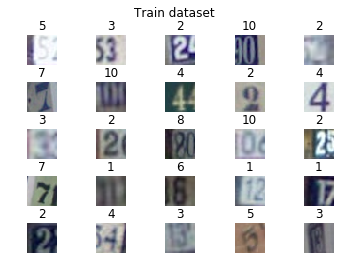

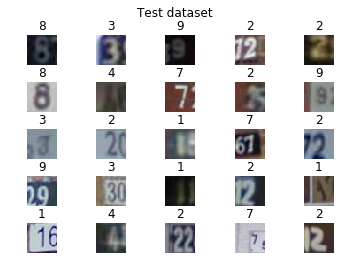

In [3]:
import random

def display_samples(dataset, labels, title = None):
    fig = plt.figure()
    if title:
        plt.suptitle(title)
    image_sample = random.sample(range(dataset.shape[3]), 25)
    for i, item in enumerate(image_sample):
        plt.subplot(5,5, i + 1)
        plt.title(labels[item][0])
        plt.axis('off')
        plt.imshow(dataset[:,:,:,item])
    plt.subplots_adjust(hspace = 0.6)
    plt.show()

display_samples(train_data, train_labels, 'Train dataset')
display_samples(test_data, test_labels, 'Test dataset')

check if the data is balanced

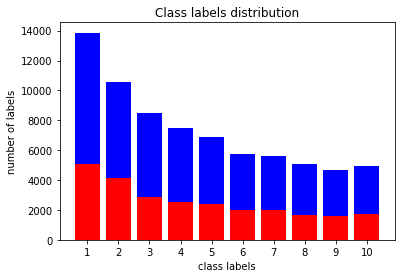

In [4]:
from collections import Counter

temp_labels = train_labels.reshape(train_labels.shape[0]).tolist()
temp_labels = dict(Counter(temp_labels))  #{key(label): value(number of instances)}
plt.bar(range(len(temp_labels)), temp_labels.values(), align = 'center',
        color = 'blue', label = 'Train labels')

temp_labels = test_labels.reshape(test_labels.shape[0]).tolist()
temp_labels = dict(Counter(temp_labels))  
plt.bar(range(len(temp_labels)), temp_labels.values(), align = 'center', 
        color = 'red', label = 'Test labels')

plt.xticks(range(len(temp_labels)), (range(1,(len(temp_labels) + 1))))
plt.xlabel('class labels')
plt.ylabel('number of labels')
plt.title('Class labels distribution')
plt.show()

Convert the shape of the data to a more intuitive version:

In [5]:
train_data = train_data.transpose((3,0,1,2))
train_labels = train_labels[:,0]
test_data = test_data.transpose((3,0,1,2))
test_labels = test_labels[:,0]

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(73257, 32, 32, 3) (73257,)
(26032, 32, 32, 3) (26032,)


Convert the RGB image to grey scale using average, reference see [grayscale_conversion](https://samarthbhargav.wordpress.com/2014/05/05/image-processing-with-python-rgb-to-grayscale-conversion/)

In [6]:
def rgb_to_grey(dataset):
    grey = np.average(dataset, axis = 3)
    return grey

train_data = rgb_to_grey(train_data)
test_data = rgb_to_grey(test_data)
     
print(train_data.shape, test_data.shape)

(73257, 32, 32) (26032, 32, 32)


Check if the images are still ok:

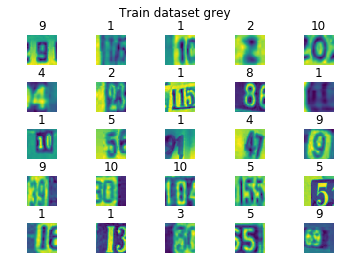

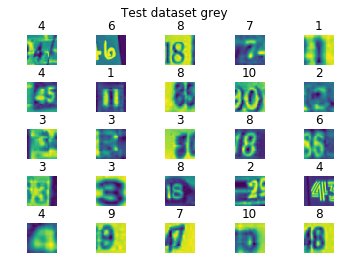

In [7]:
def display_samples(dataset, labels, title = None):
    fig = plt.figure()
    if title:
        plt.suptitle(title)
    image_sample = random.sample(range(dataset.shape[0]), 25)
    for i, item in enumerate(image_sample):
        plt.subplot(5,5, i + 1)
        plt.title(labels[item])
        plt.axis('off')
        plt.imshow(dataset[item,:,:])
    plt.subplots_adjust(hspace = 0.6)
    plt.show()

display_samples(train_data, train_labels, 'Train dataset grey')
display_samples(test_data, test_labels, 'Test dataset grey')

Check the mean and standard deviation of the data:

In [8]:
print('train dataset mean: %f, standard deviation: %f' % (np.mean(train_data), np.std(train_data)))
print('test dataset mean: %f, standard deviation: %f' % (np.mean(test_data), np.std(test_data)))

train dataset mean: 115.111780, standard deviation: 49.476878
test dataset mean: 116.781171, standard deviation: 56.227676


In [9]:
train_data_backup = train_data
test_data_backup = test_data

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

Normalized dataset tensor: (73257, 32, 32)
Mean: -4.06656e-09
Standard deviation: 0.494769
Normalized dataset tensor: (26032, 32, 32)
Mean: 1.3738e-09
Standard deviation: 0.562277


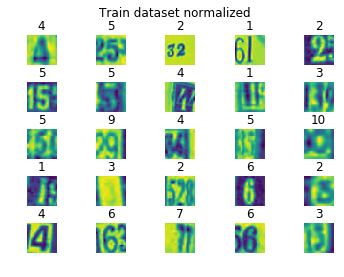

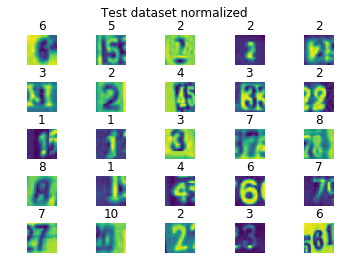

In [10]:
image_size = 32 # pixel width and height
pixel_depth = 100.0 # number of levels per pixel

def normalize_data(dataset):
    output_dataset = np.ndarray(shape = dataset.shape, dtype = np.float32)
    dataset_mean = np.mean(dataset)
    num_image = 0
    for image in dataset:
        try:
            image_data = (image - dataset_mean) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            output_dataset[num_image, :, :] = image_data
            num_image += 1
        except IOError as e:
            print('Could not read:', image, ':', e, '- it\'s ok, skip it.')
            
    output_dataset = output_dataset[0:num_image, :, :]
    print('Normalized dataset tensor:', output_dataset.shape)
    print('Mean:', np.mean(output_dataset))
    print('Standard deviation:', np.std(output_dataset))
    
    return output_dataset

train_data = normalize_data(train_data_backup)
test_data = normalize_data(test_data_backup)
display_samples(train_data, train_labels, 'Train dataset normalized')
display_samples(test_data, test_labels, 'Test dataset normalized')

In [11]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(73257, 32, 32) (73257,)
(26032, 32, 32) (26032,)


the minimum number of instances in a single label is: 4659


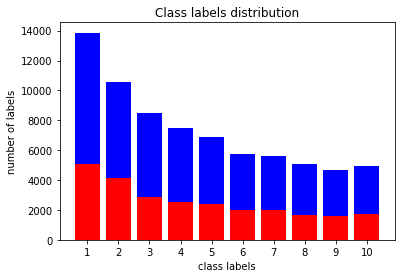

In [12]:
temp_labels = train_labels.reshape(train_labels.shape[0]).tolist()
temp_labels = dict(Counter(temp_labels))  #{key(label): value(number of instances)}

min_num = min(temp_labels.values())
print('the minimum number of instances in a single label is:', min_num)
        
plt.bar(range(len(temp_labels)), temp_labels.values(), align = 'center',
        color = 'blue', label = 'Train labels')

temp_labels = test_labels.reshape(test_labels.shape[0]).tolist()
temp_labels = dict(Counter(temp_labels))  
plt.bar(range(len(temp_labels)), temp_labels.values(), align = 'center', 
        color = 'red', label = 'Test labels')

plt.xticks(range(len(temp_labels)), (range(1,(len(temp_labels) + 1))))
plt.xlabel('class labels')
plt.ylabel('number of labels')
plt.title('Class labels distribution')
plt.show()

In [13]:
train_data_backup = train_data
train_labels_backup = train_labels
test_data_backup = test_data
test_labels_backup = test_labels

In ordor to have a balanced dataset, take 4600 sample per label category in the train dataset.

In [14]:
num_sample = 4600
num_class = 10

def select_sample(dataset, label, target_label, num_sample):
    index = np.random.permutation(np.squeeze(np.argwhere(label == target_label)))
    index_list = random.sample(list(index), num_sample)
    output_dataset = dataset[index_list, :, :]
    output_label = label[index_list]
    return output_dataset, output_label

def create_balanced_dataset(dataset, label, num_sample):
    output_dataset = np.ndarray((num_sample*num_class, image_size, image_size),
                                dtype = np.float32)
    output_labels = np.ndarray(num_sample*num_class, dtype = np.int32)
    for i in range(num_class):
        target_label = i + 1
        output_dataset[i*num_sample:(i + 1)*num_sample], output_labels[i*num_sample:(
            i + 1)*num_sample] = select_sample(dataset, label, target_label, num_sample)
    return output_dataset, output_labels

train_data,train_labels = create_balanced_dataset(train_data_backup, 
                                                  train_labels_backup, num_sample)

train_data_split = np.split(train_data, num_class)
train_labels_split = np.split(train_labels, num_class)

print(train_data.shape, train_labels.shape)

(46000, 32, 32) (46000,)


Check if the data is still good and balanced:

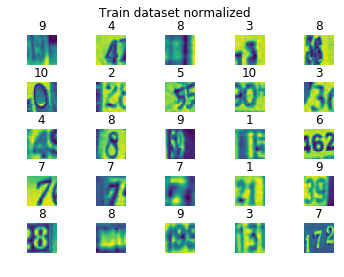

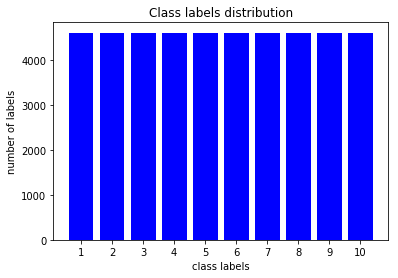

In [15]:
display_samples(train_data, train_labels, 'Train dataset normalized')

temp_labels = train_labels.reshape(train_labels.shape[0]).tolist()
temp_labels = dict(Counter(temp_labels))  #{key(label): value(number of instances)}
        
plt.bar(range(len(temp_labels)), temp_labels.values(), align = 'center',
        color = 'blue', label = 'Train labels')

plt.xticks(range(len(temp_labels)), (range(1,(len(temp_labels) + 1))))
plt.xlabel('class labels')
plt.ylabel('number of labels')
plt.title('Class labels distribution')
plt.show()

In [16]:
train_data_backup = train_data
train_labels_backup = train_labels

Create a validation dataset:

(40000, 32, 32) (40000,)
(6000, 32, 32) (6000,)
(10000, 32, 32) (10000,)


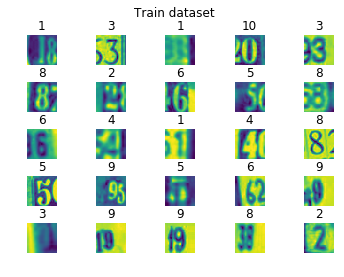

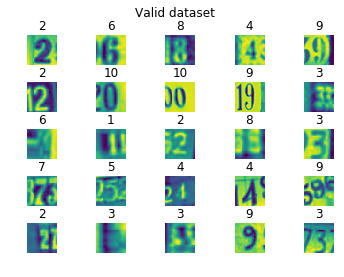

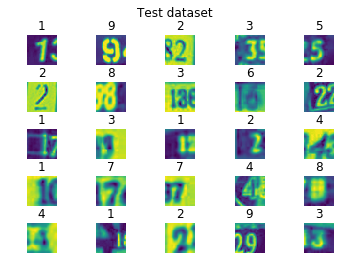

In [17]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def create_dataset(train_data_split, train_labels_split, 
                   image_size, train_size, valid_size):
    output_train_data, output_train_labels = make_arrays(train_size, image_size)
    output_valid_data, output_valid_labels = make_arrays(valid_size, image_size)
    tsize_per_class = train_size//num_class
    vsize_per_class = valid_size//num_class
    
    for i in range(num_class):
        start_t = i*tsize_per_class
        end_t = (i + 1)*tsize_per_class
        start_v = i*vsize_per_class
        end_v = (i + 1)*vsize_per_class
        
        output_train_data[start_t:end_t] = train_data_split[i][:tsize_per_class]
        output_train_labels[start_t:end_t] = train_labels_split[i][:tsize_per_class]
        output_valid_data[start_v:end_v] = train_data_split[i][
            tsize_per_class:tsize_per_class + vsize_per_class]
        output_valid_labels[start_v:end_v] = train_labels_split[i][
            tsize_per_class:tsize_per_class + vsize_per_class]
    
    return output_train_data, output_train_labels, output_valid_data, output_valid_labels

train_size = 40000
valid_size = 6000
test_size = 10000

train_data, train_labels, valid_data, valid_labels = create_dataset(
    train_data_split, train_labels_split, image_size, train_size, valid_size)

# generate test dataset
index_list = random.sample(range(test_labels_backup.shape[0]), test_size)
test_data = test_data_backup[index_list, :, :]
test_labels = test_labels_backup[index_list]


print(train_data.shape, train_labels.shape)
print(valid_data.shape, valid_labels.shape)
print(test_data.shape, test_labels.shape)

display_samples(train_data, train_labels, 'Train dataset')
display_samples(valid_data, valid_labels, 'Valid dataset')
display_samples(test_data, test_labels, 'Test dataset')

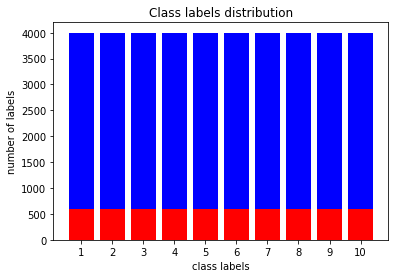

In [18]:
temp_labels = train_labels.reshape(train_labels.shape[0]).tolist()
temp_labels = dict(Counter(temp_labels))  #{key(label): value(number of instances)}
        
plt.bar(range(len(temp_labels)), temp_labels.values(), align = 'center',
        color = 'blue', label = 'Train labels')

temp_labels = valid_labels.reshape(valid_labels.shape[0]).tolist()
temp_labels = dict(Counter(temp_labels))  #{key(label): value(number of instances)}
        
plt.bar(range(len(temp_labels)), temp_labels.values(), align = 'center',
        color = 'red', label = 'Valid labels')

plt.xticks(range(len(temp_labels)), (range(1,(len(temp_labels) + 1))))
plt.xlabel('class labels')
plt.ylabel('number of labels')
plt.title('Class labels distribution')
plt.show()

We'll shuffle the data, it is important to have the labels well shuffled for training and test distributions to match.

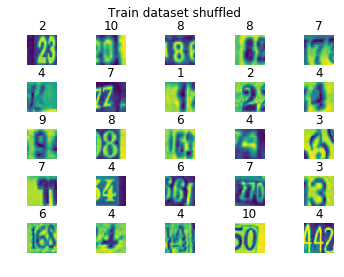

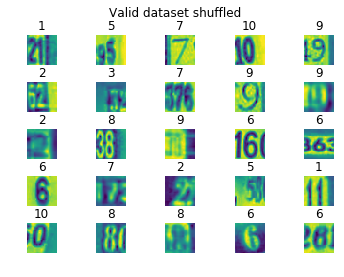

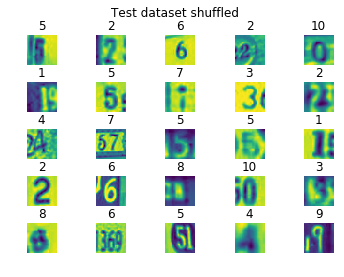

In [19]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0]) 
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_data, train_labels)
valid_dataset, valid_labels = randomize(valid_data, valid_labels)
test_dataset, test_labels = randomize(test_data, test_labels)

display_samples(train_dataset, train_labels, 'Train dataset shuffled')
display_samples(valid_dataset, valid_labels, 'Valid dataset shuffled')
display_samples(test_dataset, test_labels, 'Test dataset shuffled')

Let's save the data for later use:

In [20]:
pickle_file = os.path.join(data_root, 'google_svhn_format2.pickle')

if os.path.exists(pickle_file):
      print('%s already present - Skipping pickling.' % pickle_file)
else:
    try:
      f = open(pickle_file, 'wb')
      save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 229570537
